<a href="https://colab.research.google.com/github/AUT-Student/NN-HW8/blob/main/NN_HW8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Source

https://www.tensorflow.org/text/tutorials/transformer

# Library

In [1]:
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.6 MB 13.8 MB/s 
     |████████████████████████████████| 511.7 MB 6.3 kB/s 
     |████████████████████████████████| 1.6 MB 38.2 MB/s 
     |████████████████████████████████| 5.8 MB 55.1 MB/s 
     |████████████████████████████████| 438 kB 47.2 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Unins

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds
import tensorflow_text

from keras.layers import Dense, Input, MultiHeadAttention, LayerNormalization, Layer, Embedding
from keras.models import Sequential
import keras.backend as K

# Dataset

In [3]:
dataset = tfds.load('ted_hrlr_translate/pt_to_en', with_info=False, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteCRA6KU/ted_hrlr_translate-train.tfrecord


  0%|          | 0/51785 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteCRA6KU/ted_hrlr_translate-validation.tfrecord


  0%|          | 0/1193 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteCRA6KU/ted_hrlr_translate-test.tfrecord


  0%|          | 0/1803 [00:00<?, ? examples/s]

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [4]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]
valid_dataset = dataset["validation"]

In [5]:
# for i, data in enumerate(train_dataset):
#   print(f"i = {i}")
#   print(data[0])
#   print(data[1])
  
#   if i>5: break

# Tokenization

In [6]:
tokenizers_model_name = 'ted_hrlr_translate_pt_en_converter'
keras.utils.get_file(
    f'{tokenizers_model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{tokenizers_model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

184801/184801 [==============================] - 0s 0us/step


'./ted_hrlr_translate_pt_en_converter.zip'

In [7]:
tokenizers = tf.saved_model.load(tokenizers_model_name)
en_tokenizer = tokenizers.en
pt_tokenizer = tokenizers.pt

# Batching

In [8]:
en_length_list = np.zeros(0)
pt_length_list = np.zeros(0)
for pt_data, en_data in train_dataset.batch(4*1024):
  new_en_length_list = en_tokenizer.tokenize(en_data).row_lengths().numpy()
  new_pt_length_list = pt_tokenizer.tokenize(pt_data).row_lengths().numpy()

  en_length_list = np.concatenate((en_length_list, new_en_length_list))
  pt_length_list = np.concatenate((pt_length_list, new_pt_length_list))

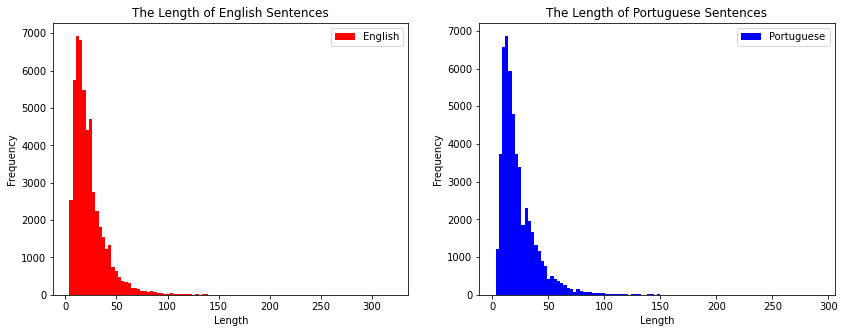

In [9]:
fig, ax = plt.subplots(1,2)

ax[0].hist(en_length_list, bins=100, color="red", label="English")
ax[1].hist(pt_length_list, bins=100, color="blue", label="Portuguese")
ax[0].legend()
ax[1].legend()
ax[0].set_title("The Length of English Sentences")
ax[1].set_title("The Length of Portuguese Sentences")
ax[0].set_xlabel("Length")
ax[1].set_xlabel("Length")
ax[0].set_ylabel("Frequency")
ax[1].set_ylabel("Frequency")

fig.set_size_inches(14, 5)
plt.show()

In [9]:
MAX_LENGTH = 128

In [10]:
def pad_dataset(dataset):
  new_dataset = []

  for pt_data, en_data in dataset.batch(1):
    en_tokens = en_tokenizer.tokenize(en_data).numpy()[0]
    pt_tokens = pt_tokenizer.tokenize(pt_data).numpy()[0]

    if len(en_tokens) > MAX_LENGTH or len(pt_tokens) > MAX_LENGTH:continue

    en_tokens = np.concatenate([en_tokens, np.zeros(MAX_LENGTH - len(en_tokens), np.int64)])
    pt_tokens = np.concatenate([pt_tokens, np.zeros(MAX_LENGTH - len(pt_tokens), np.int64)])

    new_dataset.append({"en": en_tokens, "pt": pt_tokens})

  new_dataset = pd.DataFrame(new_dataset)  
  return new_dataset

In [11]:
new_train_dataset = pad_dataset(train_dataset)

# Positional Encoding

In [12]:
def positional_encoding(position, d_model):
  encoding = np.zeros(d_model)

  for j in range(d_model):
    i = j//2
    angle = position/(10000**(2*i/d_model))

    if j%2==0:
      encoding[j] = np.sin(angle)
    else:
      encoding[j] = np.cos(angle)

  return encoding

In [13]:
positional_encoding_list = []
d_model = 512

for position in range(MAX_LENGTH):
  positional_encoding_list.append(positional_encoding(position, d_model))

In [27]:
positional_encoding_tensor = K.constant(positional_encoding_list)

# Transformer FeedForward

In [14]:
class TransformerFeedForward(Layer):
  def __init__(self, dff, d_model):
    self.model = Sequential([
                             Dense(dff, activation="relu"),
                             Dense(d_model)

    ])
  
  def call(self, inputs):
    self.model.call(inputs)

# Encoder Block

In [19]:
class EncoderBlock(Layer):
  def __init__(self, d_model, number_heads, dff):
    self.super().__init__()

    self.multi_head_attention = MultiHeadAttention(d_model=d_model, num_heads=number_heads)

    self.feedforward = TransformerFeedForward(dff=dff, d_model=d_model)

    self.normal_1 = LayerNormalization(epsilon=1e-6)
    self.normal_2 = LayerNormalization(epsilon=1e-6)

  def call(self, x, mask):
    attention_output = self.multi_head_attention(x, x, x, mask)[0]

    normal_output = self.normal_1(attention_output + x)

    feedforward_output = self.feedforward(normal_output)

    output = self.normal_2(feedforward_output + x) 

    return output

# Decoder Block

In [18]:
class DecoderBlock(Layer):
  def __init__(self, number_heads, dff, d_model):
    self.super().__init__()

    self.multi_head_attention_1 = MultiHeadAttention(d_model=d_model, num_heads=number_heads)
    self.multi_head_attention_2 = MultiHeadAttention(d_model=d_model, num_heads=number_heads)
    
    self.feedforward = TransformerFeedForward(dff=dff, d_model=d_model)

    self.normal_1 = LayerNormalization(epsilon=1e-6)
    self.normal_2 = LayerNormalization(epsilon=1e-6)
    self.normal_3 = LayerNormalization(epsilon=1e-6)

  def call(self, x, encoder_output, look_ahead_mask, padding_mask):
    attention_output_1, attention_weights_1 = self.multi_head_attention_1(x, x, x, look_ahead_mask)

    normal_output_1 = self.normal_1(attention_output_1 + x)

    attention_output_2, attention_weights_2 = self.multi_head_attention_2(encoder_output, encoder_output, normal_output_1, padding_mask)

    normal_output_2 = self.normal_2(attention_output_2 + normal_output_1)

    feedforward_output = self.feedforward(normal_output_2)

    normal_output_3 = self.normal_3(feedforward_output + normal_output_2)

    return normal_output_3, attention_weights_1, attention_weights_2

# Encoder

<tf.Tensor: shape=(128, 512), dtype=float32, numpy=
array([[ 0.0000000e+00,  1.0000000e+00,  0.0000000e+00, ...,
         1.0000000e+00,  0.0000000e+00,  1.0000000e+00],
       [ 8.4147096e-01,  5.4030228e-01,  8.2185620e-01, ...,
         1.0000000e+00,  1.0366329e-04,  1.0000000e+00],
       [ 9.0929741e-01, -4.1614684e-01,  9.3641472e-01, ...,
         1.0000000e+00,  2.0732658e-04,  1.0000000e+00],
       ...,
       [-6.1604047e-01,  7.8771454e-01,  9.3282741e-01, ...,
         9.9990976e-01,  1.2957549e-02,  9.9991608e-01],
       [ 3.2999083e-01,  9.4398415e-01,  8.2756120e-01, ...,
         9.9990833e-01,  1.3061203e-02,  9.9991471e-01],
       [ 9.7263008e-01,  2.3235910e-01,  1.0087590e-02, ...,
         9.9990690e-01,  1.3164858e-02,  9.9991333e-01]], dtype=float32)>

In [29]:
class Encoder(Layer):
  def __init__(self, number_blocks, dff, d_model, source_vocab_size, number_heads, positional_encoding_tensor):
    self.super().__init__()

    self.positional_encoding_tensor = positional_encoding_tensor

    self.embedding = Embedding(source_vocab_size, d_model)

    self.number_blocks = number_blocks

    self.encoder_blocks = []

    for _ in range(number_blocks):
      self.encoder_blocks.append(EncoderBlock(d_model=d_model, number_heads=number_heads, dff=dff))

  def call(self, x, mask):
    self.embedding(x)

    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    
    x += self.positional_encoding_tensor

    for i in range(self.num_layers):
      x = self.encoder_blocks[i](x, mask)

    return x 

# Decoder

In [ ]:
class Decoder(Layer):
  def __init__(self, number_blocks, dff, d_model, number_heads, target_vocab_size, positional_encoding_tensor):
    self.super().__init__()

    self.positional_encoding_tensor = positional_encoding_tensor

    self.embedding = Embedding(target_vocab_size, d_model)

    self.number_blocks = number_blocks
    
    self.decoder_blocks = []

    for _ in range(number_blocks):
      self.decoder_blocks.append(DecoderBlock(d_model=d_model, number_heads=number_heads, dff=dff))

    def call(self, x, encoder_output, look_ahead_mask, padding_mask):

      attention_weights = []

      x = self.embedding(x)
      x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
      x += self.positional_encoding_tensor

      for i in range(self.num_layers):
        x, attention_weight_1, attention_weight_2 = self.decoder_blocks[i](x=x,
                                                           encoder_output=encoder_output,
                                                           look_ahead_mask=look_ahead_mask,
                                                           padding_mask=padding_mask)

        attention_weights.append({"1":attention_weight_1, "2":attention_weight_2})

      return x, attention_weights      


# Transformer